# Important notes
This was originally written, so that it ran on Google colab: https://colab.research.google.com/drive/1eXUbZn7AUrLiUeL62xFWRYEfhfk1_AIF?usp=sharing

# System imports

In [ ]:
from google.colab import drive
import sys
import os
import gc
import random

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
TensorFlow version: 2.14.0
PyTorch version: 2.1.0+cu118


# Torch imports

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Tensorflow imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Imports for loading and plotting

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Mounting the drive and navigating to the correct sub folder

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd 'drive/MyDrive/Colab Notebooks/DL project/MICCAI_BraTS2020_TrainingData'

/content/drive/MyDrive/Colab Notebooks/DL project


# Setting the device up, so that we utilize the gpu, instead of the cpu

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

# Setting the hyperparameters:

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
COLOR_CHANNELS = 3
LEARNING_RATE = 0.1

# Creating the model

In [ ]:
# We can switch to Leaky ReLU in a later time
def conv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same"),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same"),
        nn.ReLU(inplace = True)
    )
    conv = conv.cuda()
    return conv

def encoding_block(in_channels, out_channels, image):
    conv_block = conv(in_channels, out_channels)
    conv1 = conv_block(image)
    down_sample = nn.MaxPool2d(kernel_size = 2, stride = 2)(conv1)
    return conv1, down_sample

def decoding_block(in_channels, out_channels, skip_connection, image):
    x = nn.ConvTranspose2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=2,
        stride=2)
    x = x.cuda()
    xnew = x(image)
    x1 = torch.cat([xnew, skip_connection], 0)
    x2 = conv(in_channels, out_channels)
    x3 = x2(x1)
    return x3

# Our Unet model

In [ ]:
# This is one of the other versions of the U-net that we tried, but couldn't get working

# class Unet(nn.Module):
#   def __init__(self):
#     super(Unet, self).__init__()

#     # Maybe switch the output channels to 1?
#     self.out = nn.Conv2d(
#         in_channels=64,
#         out_channels=2,
#         kernel_size=1,
#         )

#   def forward(self, image):
#     # Testing encoding
#     x1, max1 = encoding_block(1, 64, image)
#     x2, max2 = encoding_block(64, 128, max1)
#     x3, max3 = encoding_block(128, 256, max2)
#     x4, max4 = encoding_block(256, 512, max3)

#     # Testing lowest layer
#     lowlayer = conv(512, 1024)(max4)

#     # Testing decoding
#     y1 = decoding_block(1024, 512, x4, lowlayer)
#     y2 = decoding_block(512, 256, x3, y1)
#     y3 = decoding_block(256, 128, x2, y2)
#     y4 = decoding_block(128, 64, x1, y3)

#     output = self.out(y4)

#     '''
#     # Creating the encoder
#     x1 = self.down1(image)
#     x2 = self.max_pool_2x2(x1)
#     x3 = self.down2(x2)
#     x4 = self.max_pool_2x2(x3)
#     x5 = self.down3(x4)
#     x6 = self.max_pool_2x2(x5)
#     x7 = self.down4(x6)
#     x8 = self.max_pool_2x2(x7)
#     x9 = self.down5(x8)

#     # Creating the decoder
#     x = self.up_trans_1(x9)
#     y = crop_img2(x7, x)
#     x = self.up_conv_1(torch.cat([x, y], 1))

#     x = self.up_trans_2(x)
#     y = crop_img2(x5, x)
#     x = self.up_conv_2(torch.cat([x, y], 1))

#     x = self.up_trans_3(x)
#     y = crop_img2(x3, x)
#     x = self.up_conv_3(torch.cat([x, y], 1))

#     x = self.up_trans_4(x)
#     y = crop_img2(x1, x)
#     x = self.up_conv_4(torch.cat([x, y], 1))
#     x = self.out(x)
#     '''
#     return output



# Remodeling of functions to our U-net model

In [ ]:
# Try defining all UNet parts as sequential model structures
class Convolutions(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding=1),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1),
        nn.ReLU(inplace = True)
    )

  def forward(self, image):
    return self.conv(image)

class MaxPoolEncoding(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = Convolutions(in_channels, out_channels)
    self.maxpool = nn.MaxPool2d(kernel_size = 2, stride = 2)

  def forward(self, image):
    convolutions = self.conv(image)
    maxpool = self.maxpool(convolutions)
    return convolutions, maxpool

class UpConvDecoding(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.upconv = nn.ConvTranspose2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=2,
        stride=2)
    self.convlayer = Convolutions(in_channels, out_channels)

  def forward(self, image, skipconnection):
    afterupconv = self.upconv(image)
    skipnet = torch.cat([afterupconv, skipconnection], 1)
    return self.convlayer(skipnet)

# The model

In [ ]:
class Unet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.downconv1 = MaxPoolEncoding(in_channels, 64)
    self.downconv2 = MaxPoolEncoding(64, 128)
    self.downconv3 = MaxPoolEncoding(128, 256)
    self.downconv4 = MaxPoolEncoding(256, 512)

    self.bridge = Convolutions(512, 1024)

    self.upconv1 = UpConvDecoding(1024, 512)
    self.upconv2 = UpConvDecoding(512, 256)
    self.upconv3 = UpConvDecoding(256, 128)
    self.upconv4 = UpConvDecoding(128, 64)
    self.activation = nn.Sigmoid()

    # Maybe switch the output channels to 1?
    self.out = nn.Conv2d(
        in_channels=64,
        out_channels=out_channels,
        kernel_size=1,
        )

  def forward(self, image):
    # Testing encoding
    x1, max1 = self.downconv1(image)
    x2, max2 = self.downconv2(max1)
    x3, max3 = self.downconv3(max2)
    x4, max4 = self.downconv4(max3)

    # Testing lowest layer
    lowlayer = self.bridge(max4)

    # Testing decoding
    y1 = self.upconv1(lowlayer, x4)
    y2 = self.upconv2(y1, x3)
    y3 = self.upconv3(y2, x2)
    y4 = self.upconv4(y3, x1)

    output = self.out(y4)
    return self.activation(output)

Test for runtime error in our model

In [ ]:
image = torch.rand(1,3, 240, 240)
print(image.size())
model = Unet(3, 4)
model = model.cuda()
model(image.cuda())

torch.Size([1, 3, 240, 240])


tensor([[[[0.4896, 0.4892, 0.4888,  ..., 0.4891, 0.4890, 0.4895],
          [0.4895, 0.4899, 0.4914,  ..., 0.4899, 0.4917, 0.4902],
          [0.4897, 0.4907, 0.4915,  ..., 0.4917, 0.4913, 0.4900],
          ...,
          [0.4900, 0.4904, 0.4920,  ..., 0.4900, 0.4913, 0.4900],
          [0.4898, 0.4907, 0.4917,  ..., 0.4904, 0.4910, 0.4897],
          [0.4899, 0.4909, 0.4906,  ..., 0.4897, 0.4908, 0.4893]],

         [[0.4898, 0.4885, 0.4882,  ..., 0.4891, 0.4877, 0.4884],
          [0.4898, 0.4883, 0.4889,  ..., 0.4897, 0.4891, 0.4888],
          [0.4899, 0.4901, 0.4890,  ..., 0.4902, 0.4886, 0.4892],
          ...,
          [0.4895, 0.4889, 0.4895,  ..., 0.4894, 0.4892, 0.4890],
          [0.4895, 0.4881, 0.4904,  ..., 0.4894, 0.4898, 0.4892],
          [0.4878, 0.4889, 0.4889,  ..., 0.4885, 0.4895, 0.4890]]]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

# Define functions for retrieving the files.

In [ ]:
# Make sure to change all relevant paths to your own directory the repo is saved in :)
# These functions are relevant for fetching and loading images in case you wish to perform your own npy generated files
def getNiiFiles(base_filename, path):
    nii_files = []
    for root, _, files in os.walk(path):
        subfolder_name = os.path.basename(root)
        for file in files:
            if file.endswith(f'{base_filename}.nii') and not file.endswith(f'{base_filename}.nii.gz'):
                nii_files.append(path + subfolder_name + '/' + file)
    return nii_files

def load_and_transform_img(img_path):
    # Load the image data from the file
    img_data = nib.load(img_path).get_fdata()

    # Reshape, scale and then reshape back to original shape
    transformed_data = scaler.fit_transform(img_data.reshape(-1, img_data.shape[-1])).reshape(img_data.shape)

    return transformed_data

# Function for showing different nii files in same figure
def showNiiFile(currentfile):
  img = nib.load(currentfile).get_fdata()
  fig_rows = 4
  fig_cols = 4
  n_subplots = fig_rows * fig_cols
  n_slice = img.shape[2]
  step_size = n_slice // n_subplots
  plot_range = n_subplots * step_size
  start_stop = int((n_slice - plot_range) / 2)
  fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10,10])

  for index, sliceNumber in enumerate(range(start_stop, plot_range, step_size)):
    if sliceNumber > n_slice: break
    axs.flat[index].imshow(img[:, :, sliceNumber], cmap='gray')
    axs.flat[index].axis('off')

  plt.tight_layout()
  plt.show()

# This is how we originally builed our dataset, before converting the NIfTI files to npy files.
# files: the output of getNiiFile.
def buildDataset(files):
  dataset = []
  for i in range(len(files)):
    #print(f"At file no: {i}")
    brain_scan = nib.load(files[i])
    dataset.append(brain_scan)
    gc.collect()
  return dataset

Each file element in `files` is a 3d array (the `img` is the 3d array, but is derived from `files`). The first and second dimensions are for the pixel positions. The third dimension is the number of slices of the MRI scan on a brain and counts to 155 slices.

In [ ]:
files = getNiiFile("seg")

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.RandomRotation(45),
])
# img = nib.load(files[0])
# print(img.header)
img = nib.load(files[0]).get_fdata() # Get the brain scan as a 3d array
print(np.max(img))
plt.imshow(img[:,:,130], cmap="gray") # Show the 130th slice of the brain scan.

# Preprocess the data

In [ ]:
t2_list = getNiiFile("t2")
t1ce_list = getNiiFile("t1ce")
flair_list = getNiiFile("flair")
mask_list = getNiiFile("seg")

# Some code to understand the preprocessing

In [ ]:
img = 20

# Loading the different
temp_t2 = load_and_transform_img(t2_list[img])
temp_t1ce = load_and_transform_img(t1ce_list[img])
temp_flair = load_and_transform_img(flair_list[img])

temp_mask=nib.load(mask_list[img]).get_fdata()
temp_mask=temp_mask.astype(np.uint8)
temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

combined_images = np.stack([temp_flair, temp_t1ce, temp_t2], axis=3)

# Transform data to remove a lot of background while keeping interesting pixels in the image, this results in 128x128x128x3 dimensions
combined_images = combined_images[56:184, 56:184, 13:141]
temp_mask = temp_mask[56:184, 56:184, 13:141]

temp_mask= to_categorical(temp_mask, num_classes = 4)

shape of temp_image_t2: (240, 240, 155)
shape after scaler.fit_transform: (240, 240, 155)
shape of temp_mask: (240, 240, 155)


# Preprocess the data and store them as npy files

In [ ]:
# This needs rewriting, since it's taken from the baseline model in "keras_implementation.ipynb", which is written to work locally instead of on Google Colab

def generate_npy(folder):
    for img in range(len(flair_list)):
        print('Now preparing image and masks number: ', img)

        temp_t2 = load_and_transform_img(t2_list[img])

        temp_t1ce = load_and_transform_img(t1ce_list[img])

        temp_flair = load_and_transform_img(flair_list[img])

        temp_mask=nib.load(mask_list[img]).get_fdata()
        temp_mask=temp_mask.astype(np.uint8)
        temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3

        combined_images = np.stack([temp_flair, temp_t1ce, temp_t2], axis=3)

        # Transform data to remove a lot of background while keeping interesting pixels in the image, this results in 128x128x128x3 dimensions
        combined_images = combined_images[56:184, 56:184, 13:141]
        temp_mask = temp_mask[56:184, 56:184, 13:141]

        temp_mask= to_categorical(temp_mask, num_classes = 4)
        if folder.lower().contains('train'):
            np.save('D:\Skrivebord\BRATS\\npy files\images/image_'+str(img)+'.npy', combined_images)
            np.save('D:\Skrivebord\BRATS\\npy files\masks/mask_'+str(img)+'.npy', temp_mask)
        elif folder.lower().contains('vali'):
            np.save('D:\Skrivebord\BRATS\\npy files\images/image_'+str(img)+'.npy', combined_images)
            np.save('D:\Skrivebord\BRATS\\npy files validation\masks/mask_'+str(img)+'.npy', temp_mask)
        else:
            print("Please include a string containing either 'train' or 'vali'")
            return



## Getting data ready

Define dataset class for brain tumors.

In [ ]:
class BrainTumorDataset(Dataset):

  # examples: output of buildDataset of flair, t1, t1ce or t2 files
  # truth: output of buildDataset of seg files.
  def __init__(self, examples, truth, transform=None):
    self.root_dir = "MICCAI_BraTS2020_TrainingData"
    self.data_examples = examples
    self.data_truth = truth
    self.transform = transform
    # self.batch_iter = 1

  def __len__(self):
    return len(self.data_examples)

  def __getitem__(self, idx):
    # sample = {'examples': self.data_examples[batch_size*(self.batch_iter-1):batch_size*self.batch_iter], 'truths': self.data_truth[batch_size*(self.batch_iter-1):batch_size*self.batch_iter]}
    # self.batch_iter += 1
    example = self.data_examples[idx].get_fdata(caching='unchanged')
    truth = self.data_truth[idx].get_fdata(caching='unchanged')
    # sample = {'example': example, 'truth': truth}
    #if self.transform:
      # sample = self.transform(sample)
    self.data_examples[idx].uncache()
    self.data_truth[idx].uncache()
    gc.collect()
    return example, truth

  # def resetBatch(self):
  #   self.batch_iter = 1

  # def permuteData(self):
  #   permumatrix = np.hstack((self.data_examples[:, np.newaxis], self.data_truth[:, np.newaxis]))
  #   postPermutation = np.random.permutation(permumatrix)
  #   examplePermute = postPermutation[:,0]
  #   truthPermute = postPermutation[:,1]
  #   self.data_examples = examplePermute[np.newaxis, :]
  #   self.data_truth = truthPermute[np.newaxis, :]
  #   return "Success!"



# Loading the stored numpy files

In [ ]:
def fetch_and_process_images(directory, filenames):
    def process_image(file):
        return np.load(directory + file) if file.endswith('.npy') else None

    processed_images = [process_image(f) for f in filenames if process_image(f) is not None]
    return np.stack(processed_images)

def batched_image_mask_generator(image_path, image_files, mask_path, mask_files, size_of_batch):
    total_images = len(image_files)

    def get_batch(slice_start, slice_end):
        image_batch = fetch_and_process_images(image_path, image_files[slice_start:slice_end])
        mask_batch = fetch_and_process_images(mask_path, mask_files[slice_start:slice_end])
        return image_batch, mask_batch

    start, end = 0, size_of_batch
    # Infinite while loop is important for Keras generators
    while True:
        if start >= total_images:
            start, end = 0, size_of_batch
        # Important to yield for it to function as a generator!
        yield get_batch(start, min(end, total_images))
        start, end = end, end + size_of_batch

In [ ]:
# Paths needs to we rewritten, if you have a different folder structure
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/DL project/npy files/images/"
train_mask_dir = "/content/drive/MyDrive/Colab Notebooks/DL project/npy files/masks/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

A sanity check to see that the data is in order

In [ ]:
img_list = load_img(train_img_dir, train_img_list[0:40])
mask_list = load_img(train_mask_dir, train_mask_list[0:40])

# Plotting some data, so see that our generator works

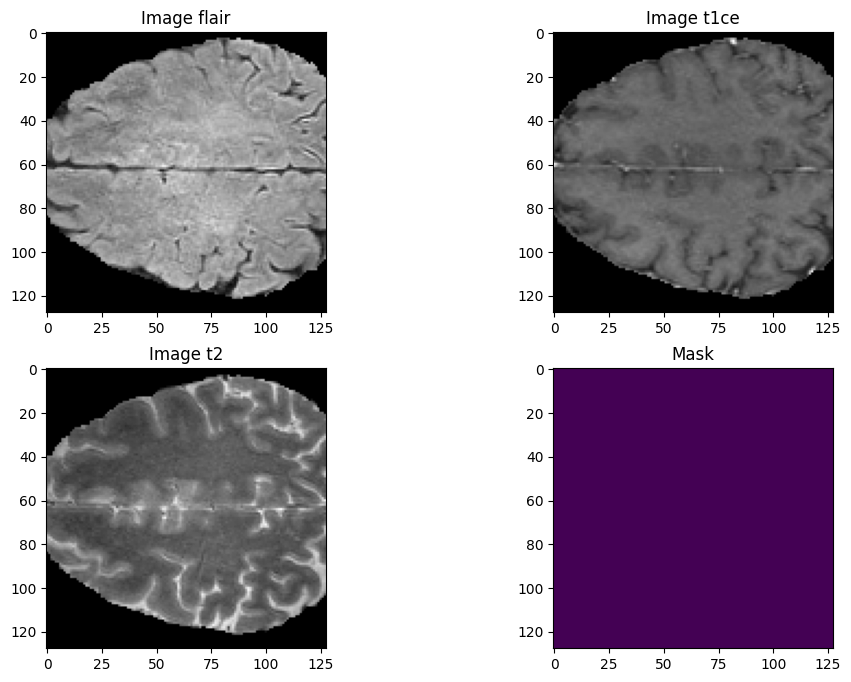

In [ ]:
batch_size = 2

train_loader = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

img, msk = train_loader.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

# Training

## Loss function and optimizer

Here is the source, for Binary Dice loss:
https://github.com/hubutui/DiceLoss-PyTorch/blob/master/loss.py

Pytorch did not have its own dice loss function, so we used this one from github

In [ ]:
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


In [ ]:
# Set loss function
loss_fn = BinaryDiceLoss()

An optimizer for modifying the model parameters during gradient descent. (Do some tweaking on hyperparameters here during experimentation).

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)


In [ ]:
""" Deprecated """
def train(epoch, start_slice = 50, end_slice = 80):
  for epoch in range(epoch):
    print("Epoch: ", epoch)
    #Do something to reset all necessary variables after each epoch
    model.train()
    running_loss = 0
    for i, data in enumerate(train_loader):
      #Do basics for starting batches, make sure intermediatebatch is an exact divisor of batch_size
      example, truth = data
      example = torch.from_numpy(example).cuda()
      truth = torch.from_numpy(truth).cuda()
      for j in range(example.shape[0]):
        brain_scan = example[j].to(torch.float32)
        # relevant_slices = brain_scan[:,:,:,start_slice:end_slice]
        # plt.imshow(test, cmap="gray")
        # 2nd Dimension is the number of slices, 3rd dimension is number of channels :)
        input = torch.permute(brain_scan, (2, 3, 0, 1)).to(torch.float32)
        # test2 = input[1,0, :, :].cpu().data.numpy()
        # plt.imshow(test2, cmap="gray")
        # fig, axs = plt.subplots(1, 2, figsize=[10,10])
        # axs.flat[0].imshow(test, cmap="gray")
        # axs.flat[1].imshow(test2, cmap="gray")
        # plt.tight_layout()
        # plt.show()
        outputs = model(input)
        optimizer.zero_grad()
        # Compute the loss and its gradients
        compareTruth = truth[j]
        comparison = torch.permute(compareTruth, (2, 3, 0, 1)).to(torch.float32)
        #print(f"target size: {comparison.size()}")
        #print(f"outputs size: {outputs.size()}")
        #print(f"input size: {outputs[:,1,:,:].size()}")
        loss = loss_fn(outputs[:,1,:,:], comparison[:,0,:,:])
        loss_val = loss.item()
        running_loss += loss_val
        # print(f"Loss for batch element: {loss_val}")
        loss.backward()


        # Adjust learning weights
        optimizer.step()
        torch.cuda.synchronize()
        gc.collect()

## Actual training

In [ ]:
train(2, end_slice=55)

In [ ]:
torch.cuda.empty_cache()

#Get the validation set

In [ ]:
cd ..
cd 'Validation'

In [ ]:
validation_flair = buildDataset(getNiiFile("flair"))
validation_seg = buildDataset(getNiiFile("seg"))

validation_dataset = BrainTumorDataset(validation_flair, validation_seg, transform=transforms)
validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [ ]:
example, label = next(iter(validation_dataloader))

Apparently, the predictions of our model is random on the same input image

In [ ]:
print(label.size())
example = example.cuda()
print(example.size())
input2 = torch.permute(example, (3, 0, 1, 2)).to(torch.float32)
prediction = model(input2[100,:,:,:]).cpu().data.numpy()
#plt.imshow(prediction[0,0,:,:], cmap='gray')

If you run the plot after each prediction on same image input, you will see that the resulting feature maps will have different grayscaling.

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=[10,10])
print(input2.size())
axs.flat[0].imshow(input2[100,0,:,:].cpu().data.numpy(), cmap="gray")
axs.flat[1].imshow(prediction[0,:,:], cmap="gray")
axs.flat[2].imshow(prediction[1,:,:], cmap="gray")
axs.flat[3].imshow(label[0,:,:,100], cmap="gray")
plt.tight_layout()
plt.show()